# Modeling Delays of US Domestic Flights

This notebook visualizes and predicts the relative departure times of domestic flights. The data is from the US Department of Transportation, available [here](http://www.transtats.bts.gov/DatabaseInfo.asp?DB_ID=120&DB_Name=Airline%20On-Time%20Performance%20Data).

## Importing, Cleaning and Visualizing the Data

In [1]:
import glob
import numpy as np 
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

### Importing the Data

All of the data from the Department of Transportation comes in directories like `data_YYYY_MM/data_YYYY_MM.csv`. So for each year, there are 12 unique csv files to be loaded. Here, we're loading just the january data from all the available years and combining it into one dataframe.  

In [2]:
january_data = glob.glob('CarrierData/*/*_1.csv')

loaded_data = []

for path in january_data:
    this_data = pd.read_csv(path, skipinitialspace=True, low_memory=False)
    loaded_data.append(this_data)

df = pd.concat(loaded_data)

The airlines are represented as unique codes, so we need to import the lookup table from the DoT and create a dictionary.

In [3]:
this_data = pd.read_csv('CarrierData/carriers.csv', skipinitialspace=True, low_memory=False)

airlines_lookup = this_data.set_index('Code')['Description'].to_dict()

### Cleaning the Data

Consolidating the dataframe to just contain the relevant columns:

In [4]:
df = df[['Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'OriginCityName',
         'Dest', 'DepDelay', 'ArrDelay', 'CRSElapsedTime', 'CRSDepTime']]

There might be some missing data, so let's visualize that here. 

In [5]:
missing = df.isnull().sum(axis=0).reset_index()
missing.columns = ['Variable', 'Missing Entries']
missing['Percent Complete'] = (df.shape[0] - missing['Missing Entries']) / df.shape[0]*100
missing.sort_values('Percent Complete').reset_index(drop = True)

,Variable,Missing Entries,Percent Complete
0,ArrDelay,54476,97.186055
1,DepDelay,48994,97.469227
2,CRSElapsedTime,4,99.999793
3,Month,0,100.000000
4,DayofMonth,0,100.000000
5,DayOfWeek,0,100.000000
6,Reporting_Airline,0,100.000000
7,Origin,0,100.000000
8,OriginCityName,0,100.000000
9,Dest,0,100.000000


Since the dataset is about 97% complete, we'll just drop any rows that are missing data. It won't result in too much of a loss.

In [6]:
before = len(df.index)
df.dropna(inplace = True)
after = len(df.index)

diff = before - after

print("Removed {} entries out of {}".format(diff, before))

Removed 54952 entries out of 1935930


### Visualization

Now, we can begin to visualize the data. We'll start by taking a look at the percentage of flights delayed and mean delay time for each airline.

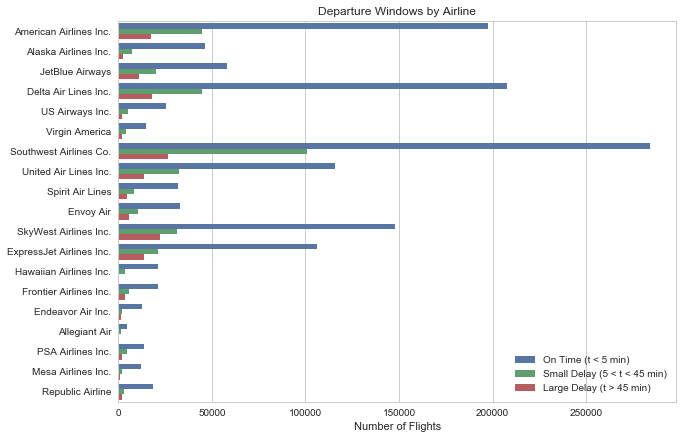

In [7]:
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['delay_amount'] = df['DepDelay'].apply(delay_type)

fig = plt.figure(1, figsize=(10,7))
plt.title('Departure Windows by Airline')
ax = sns.countplot(y='Reporting_Airline', hue='delay_amount', data=df)

df = df.drop(columns=['delay_amount'])

labels = [airlines_lookup[item.get_text()] for item in ax.get_yticklabels()]

ax.set_yticklabels(labels)

ax.yaxis.label.set_visible(False)
plt.xlabel('Number of Flights')

L = plt.legend(loc=4)
L.get_texts()[0].set_text('On Time (t < 5 min)')
L.get_texts()[1].set_text('Small Delay (5 < t < 45 min)')
L.get_texts()[2].set_text('Large Delay (t > 45 min)')
plt.show()

It appears as if the number of delayed flights scales with the size of the airline and how many flights they run, as one would expect. However, what is notable here is that there's a good amount of variation in delay times between *similarly sized airlines*. Hawaiian and Frontier are both similar sizes, but Frontier has more large delays. This indicates that the airline will be an important part of the model.

Next, we'll plot the overall distribution of departure times by airline.

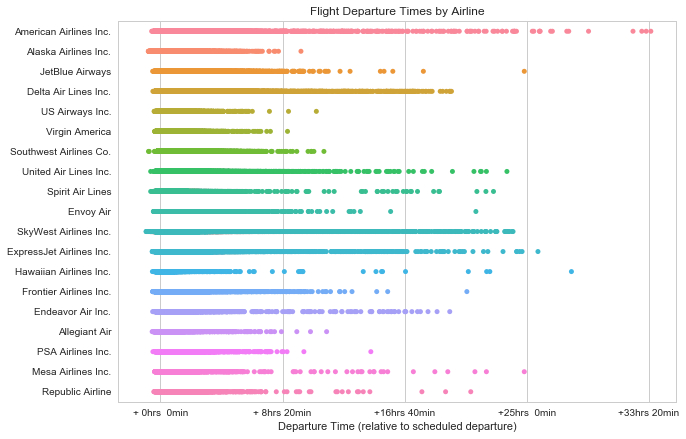

In [8]:
fig = plt.figure(1, figsize=(10,7))

plt.title('Flight Departure Times by Airline')

ax = sns.stripplot(y='Reporting_Airline', x='DepDelay', data=df)
ax.set_xticklabels(['+{:2.0f}hrs {:2.0f}min'.format(*[int(y) for y in divmod(x,60)]) for x in ax.get_xticks()])

labels = [airlines_lookup[item.get_text()] for item in ax.get_yticklabels()]

ax.set_yticklabels(labels)

plt.xlabel('Departure Time (relative to scheduled departure)')
ax.yaxis.label.set_visible(False)

plt.show()

This is a more telling visualization, as it ignores the size of the airline and just shows the overall departure time distribution for each. A tighter cluster towards the left of the graph is better, and there are clear differences between airlines once again. SkyWest, American, and Delta are of particluar note for their large distributions. 

Now let's look at the average departure and arrival times for each airline.

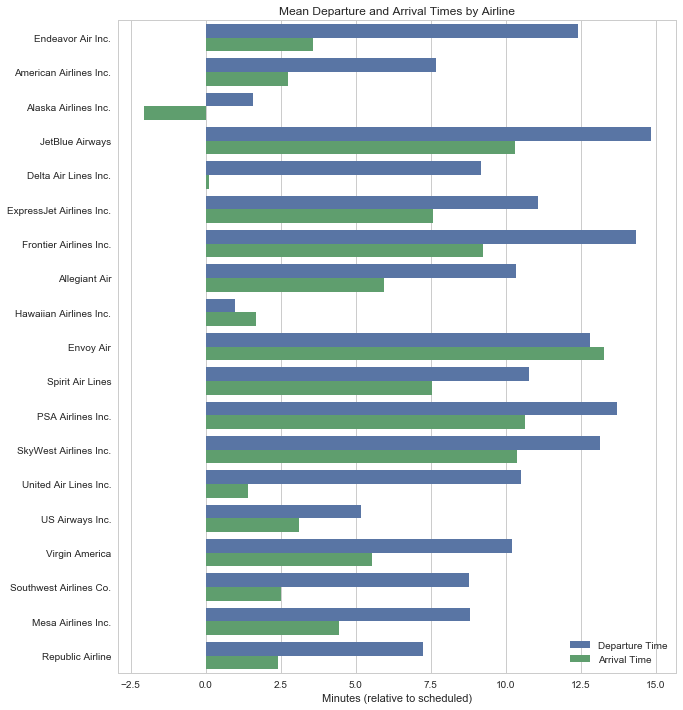

In [9]:
fig = plt.figure(1, figsize=(10,12))
plt.title('Mean Departure and Arrival Times by Airline')

dept_data = dict()
arr_data = dict()

for carrier in airlines_lookup.keys():
    delays = df[df['Reporting_Airline'] == carrier]
    del_dep = delays['DepDelay']
    del_arr = delays['ArrDelay']
    
    if del_dep.count() > 0:
        dep = del_dep.sum() / del_dep.count()
        arr = del_arr.sum() / del_arr.count()
        dept_data[carrier] = [carrier, dep, 'Departing']
        arr_data[carrier] = [carrier, arr, 'Arriving']
    
temp = []
temp.append(pd.DataFrame.from_dict(dept_data, orient='index', columns=['carrier', 'time', 'dir']))
temp.append(pd.DataFrame.from_dict(arr_data, orient='index', columns=['carrier', 'time', 'dir']))

df_temp = pd.concat(temp)

ax = sns.barplot(y='carrier', x='time', hue='dir', data=df_temp)

labels = [airlines_lookup[item.get_text()] for item in ax.get_yticklabels()]

ax.set_yticklabels(labels)

plt.xlabel('Minutes (relative to scheduled)')
ax.yaxis.label.set_visible(False)

L = plt.legend()
L.get_texts()[0].set_text('Departure Time')
L.get_texts()[1].set_text('Arrival Time')

plt.show()

Most all airlines were able to reduce their arrival times despite later departure times. Delta, United and Alaska are notable outliers that were able to get close to or less than the original scheduled arrival time.

Now let's take a look at another possibly important variable- airport.

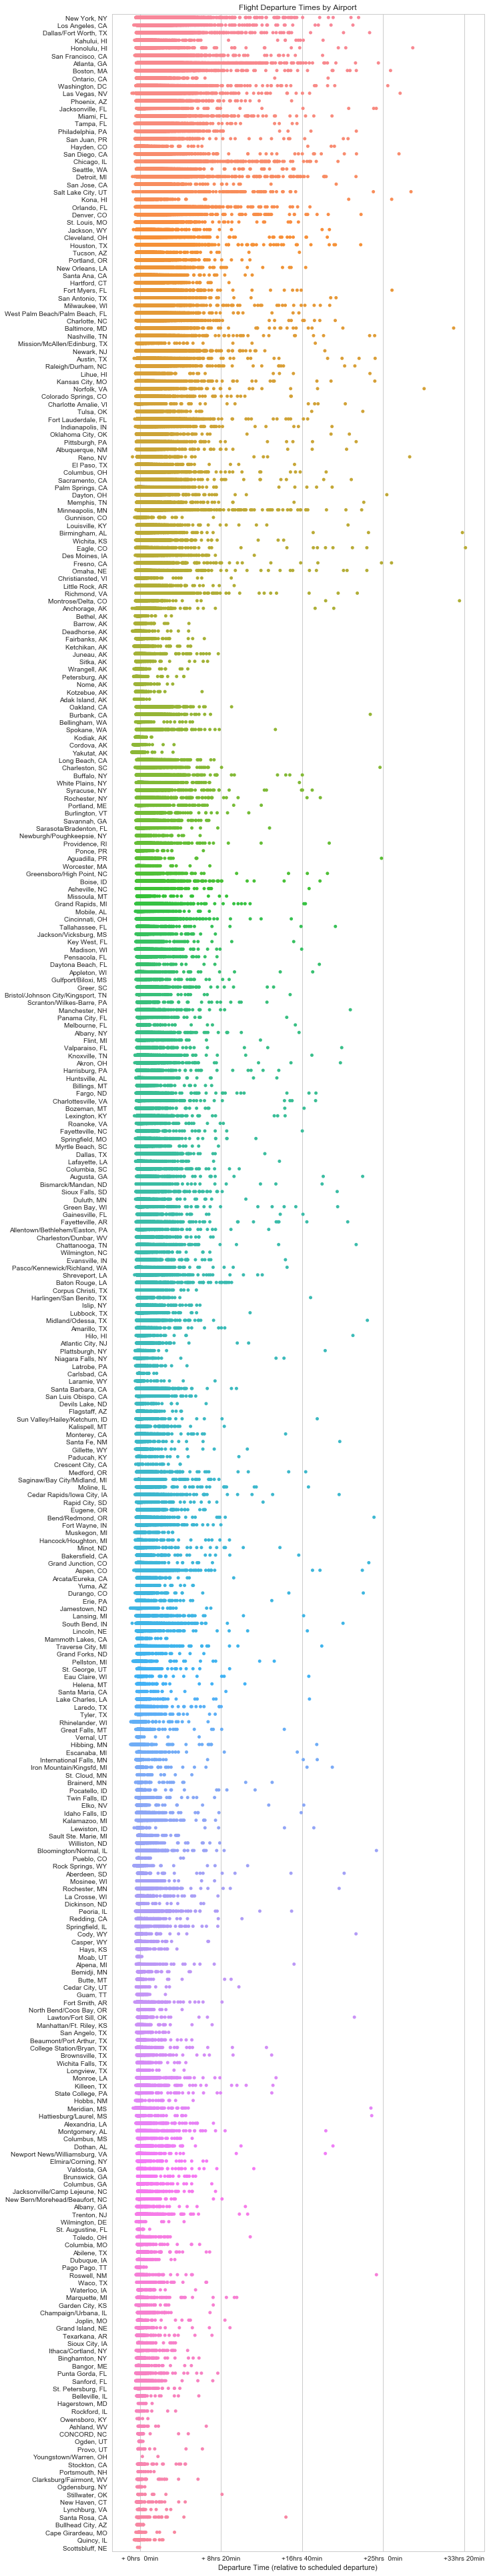

In [10]:
fig = plt.figure(1, figsize=(10,70))

plt.title('Flight Departure Times by Airport')

ax = sns.stripplot(y='OriginCityName', x='DepDelay', data=df)
ax.set_xticklabels(['+{:2.0f}hrs {:2.0f}min'.format(*[int(y) for y in divmod(x,60)]) for x in ax.get_xticks()])

plt.xlabel('Departure Time (relative to scheduled departure)')
ax.yaxis.label.set_visible(False)

plt.show()

Here we can see a similar difference between airports. Of course, this is a bit misleading since the number of flights from each airport will play a role in delays, but it shows that airport will also play an important role in the model. An interesting observation from this graph: notice that Atlanta has a larger distribution of flight departure times than Chicago. This seems unintuitive at first; Chicago is further north and must deal with more severe winter weather, which would logically lead to more delays. However, recall the distributions of Delta and United. Delta had a much larger distribution than United. Atlanta is a large hub for Delta, while Chicago is a large hub for United. Here we find an interesting case of the two variables being intertwined. 

The above strip plots were a bit misleading in that they showed the entire distribution of possible flight departures, from 0 to 33 hours after scheduled departure time. Let's now take a look at when the majority of flights depart.

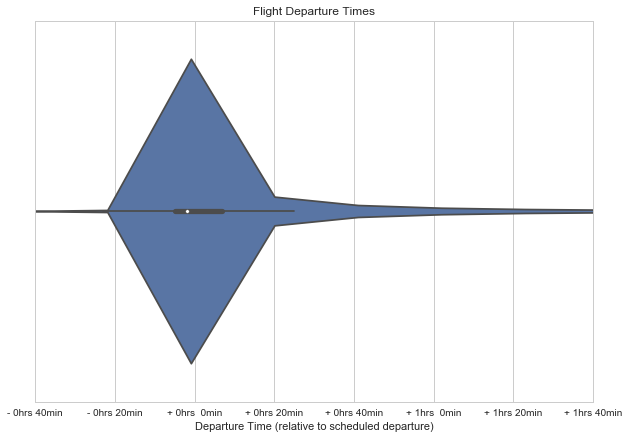

In [11]:
fig = plt.figure(1, figsize=(10,7))

plt.title('Flight Departure Times')
ax = sns.violinplot(x=df['DepDelay'])
plt.xlim(-40, 100)

ax.set_xticklabels(['{}{:2.0f}hrs {:2.0f}min'.format(('-' if x < 0 else '+'),
                                                     *[int(y) for y in divmod(abs(x),60)]) for x in ax.get_xticks()])
plt.xlabel('Departure Time (relative to scheduled departure)')
plt.show()

The range between -20 and +20 minutes seems to be when the majority of flights leave, with the mean slightly less than zero. It will be important to ensure that the model is most accurate in this range, rather than trying to accurately predict over the 33 hour possible scale, as anything over 2 hours can safely be consitered an outlier. 

Let's take a closer look at the distribution.

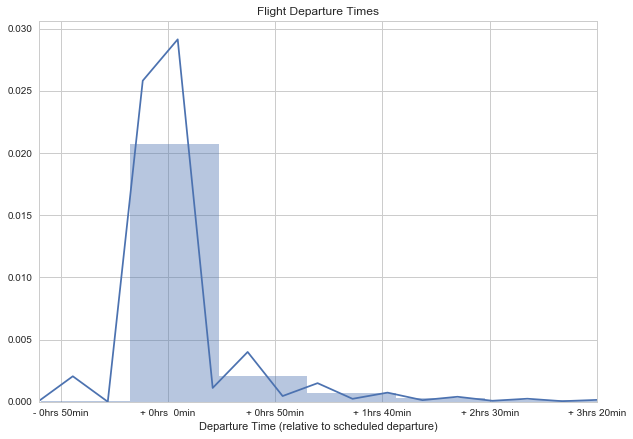

In [12]:
fig = plt.figure(1, figsize=(10,7))

plt.title('Flight Departure Times')
ax = sns.distplot(df['DepDelay'])
plt.xlim(-60, 200)

ax.set_xticklabels(['{}{:2.0f}hrs {:2.0f}min'.format(('-' if x < 0 else '+'),
                                                    *[int(y) for y in divmod(abs(x),60)]) for x in ax.get_xticks()])
plt.xlabel('Departure Time (relative to scheduled departure)')
plt.show()

## Building the Model

We'll use Tensorflow for good accuracy with a low(ish) amount of work, and to take advantage of that sweet GPU computing power.

In [13]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Method

The goal here is to predict flight departure times. That is, to predict the amount of time (in minutes, relative to scheduled departure time) that the plane will take to leave. Notice that the prediction does *not* need any specific boarding/departure time, as all the data that we're using is *relative.* So if a flight is supposed to leave at 10:30 and leaves at 10:38, we just know that it left 8 minutes late. In case it hasn't been clear above, flights that leave early are represented with negative departure times.

Another caveat: we will be predicting *average* departure times. That is, predicting flight times that are within the range that the majority of delays take place in; (-30 min, 40 min). This model will be useless when it comes to predicting really long delays, because the cause of these delays is often not implicit in the data.

This prediction relies on a number of features:

- Airline
- Origin airport
- Destination airport
- Scheduled flight duration
- Month
- Day of month
- Day of week
- Hour (maybe)

The problem with just predicting departure delays is that they aren't particularily representative of arrival delays, as shown in the visualization above. It would be nice for this application to provide this information as well. As such, we'll be building another model to predict arrival delays that uses the same features. 

Once we have the two predictions then we will be able to also predict the expected flight time. This can be done most simply by taking the expected route time and adding or subtracting both the expected arrival and departure delays.

### Cleaning MKII

There's a little more cleaning to be done here. We need to convert the airport IDs and Airline IDs to numerical codes so they can be fed into the model. 

In [14]:
df = df.drop(columns=['OriginCityName'])

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df['Origin'])
zipped = zip(df['Origin'], integer_encoded)
airports = dict(zipped)

df['Origin'] = df['Origin'].replace(to_replace=airports, value=None)
df['Dest'] = df['Dest'].replace(to_replace=airports, value=None)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df['Reporting_Airline'])
zipped = zip(df['Reporting_Airline'], integer_encoded)
airlines = dict(zipped)

df['Reporting_Airline'] = df['Reporting_Airline'].replace(to_replace=airlines, value=None)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df['CRSDepTime'])
zipped = zip(df['CRSDepTime'], integer_encoded)
dep_times = dict(zipped)

df['CRSDepTime'] = df['CRSDepTime'].replace(to_replace=dep_times, value=None)

For now, we're also dropping the elapsed time and arrival delay. 

In [15]:
df = df[df['DepDelay'] < 30]  
df = df[df['DepDelay'] > -30]  

y = df['DepDelay']
X = df.drop(columns=['DepDelay', 'CRSElapsedTime', 'CRSDepTime'])

Just to check our dataframe to make sure it looks ok:

In [16]:
X.head()

,Month,DayofMonth,DayOfWeek,Reporting_Airline,Origin,Dest,ArrDelay
0,1,1,4,1,170,180,7.0
1,1,2,5,1,170,180,-19.0
2,1,3,6,1,170,180,-39.0
3,1,4,7,1,170,180,-12.0
4,1,5,1,1,170,180,-8.0


Now we split the data.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train[:5])

        Month  DayofMonth  DayOfWeek  Reporting_Airline  Origin  Dest  \
299158      1          14          6                 13      88     2   
27164       1           2          1                  3      40   152   
330585      1           4          4                 16     188   302   
380121      1          31          3                 16      18    87   
384594      1          31          6                  4      18    69   

        ArrDelay  
299158     -19.0  
27164      -10.0  
330585      14.0  
380121     -12.0  
384594     -12.0  


Normally this would be where we might do some normalization, but the model seems to converge regardless. 

### Regression

We'll use the `Sequential` model from Tensorflow with two hidden layers and one output layer to reurn a single continuous value. We need to use a model from keras to ensure that it can be saved as a json and loaded by tensorflow js.

In [18]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

  return model

EPOCHS = 20


Now we can build and train the model. 

In [19]:
model = build_model()
model.summary()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.33, verbose=1, callbacks=[early_stop], use_multiprocessing=True)

#tf.keras.models.save_model(model, 'models/december.json', overwrite=True, include_optimizer=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 8,897
Trainable params: 8,897
Non-trainable params: 0
_________________________________________________________________
Train on 888764 samples, validate on 437750 samples
Epoch 1/20
888764/888764 [==============================] - 57s 64us/step - loss: 48.1138 - mean_absolute_error: 5.0309 - val_loss: 47.9076 - val_mean_absolute_error: 4.9436
Epoch 2/20
888764/888764 [====================

Now let's evaluate the model.

<Figure size 720x1080 with 0 Axes>

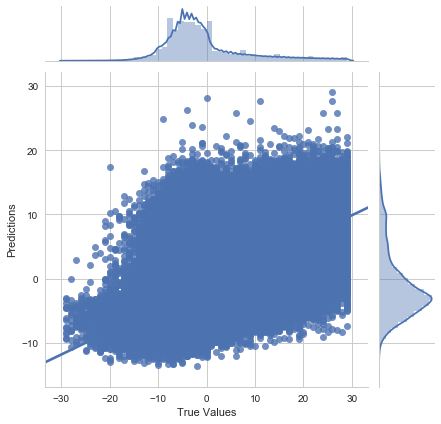

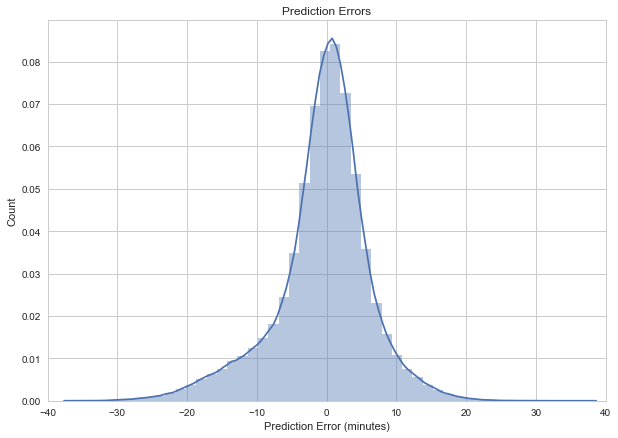

Mean Error: 4.872393582594913 minutes
Loss Value: 45.976186491640476


In [20]:
def visualize_results(model):
    
    [loss, mae] = model.evaluate(X_test, y_test, verbose=0)
    
    test_predictions = model.predict(X_test).flatten()
    
    fig = plt.figure(1, figsize=(10,15))

    ax = sns.JointGrid(x=y_test, y=test_predictions)
    ax = ax.plot(sns.regplot, sns.distplot)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()
    
    fig = plt.figure(1, figsize=(10,7))

    plt.title('Prediction Errors')
    error = test_predictions - y_test
    ax = sns.distplot(error)
    plt.xlim(-40, 40)
    plt.xlabel("Prediction Error (minutes)")
    plt.ylabel("Count")
    plt.show()
    
    print("Mean Error: {} minutes".format(mae))
    print("Loss Value: {}".format(loss))

visualize_results(model)

The model is pretty good, but not perfect. A mean error of 4.7 minutes means that predictions should be qualified with plus or minus 5 minutes. However, given the huge size of these data, it certainly is quite acceptable. Also, note that the model is slightly positively biased, so it will be a bit convervative in its estimates. This is a good thing, as it would be worse to report that a flight will be early to the user than late.

Let's determine exactly how accurate it is given a few different margins of error.

In [24]:
test_predictions = model.predict(X_test).flatten()

within_error_1 = 0
within_error_2 = 0
within_error_3 = 0
total = 0
i = 0

for real in y_test:

    pred = test_predictions[i]
    
    if abs(pred - real) <= 20:
        within_error_1 += 1
        if abs(pred - real) <= 10:
            within_error_2 +=1
            if abs(pred-real) <= 5:
                within_error_3 += 1
    
    total += 1
    i += 1
    
print("Predictions accurate to 5 minutes {}%".format(within_error_3 / total * 100))
print("Predictions accurate to 10 minutes {}%".format(within_error_2 / total * 100))
print("Predictions accurate to 20 minutes {}%".format(within_error_1 / total * 100))
        

Predictions accurate to 5 minutes 65.25153107840389%
Predictions accurate to 10 minutes 86.67366243603544%
Predictions accurate to 20 minutes 98.60356000229172%


## Wrap Up

We were able to make rather accurate flight departure time predictions from the data available from the US Department of Transportation. We started by cleaning and visualizing the data to look for important attributes and then trained a model using Tensorflow and Keras. This process is will be used for the models used to make predictions on [flygeni.us](https://flygeni.us)